In [1]:
# import sys
#!{sys.executable} -m pip install qiskit
#!{sys.executable} -m pip install qiskit-nature

In [2]:
from sys import path as syspath
from os import path as ospath
# /!\ import here https://github.com/mrfanuel/qiskit-nature

In [3]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import seaborn as sns
#from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian

from qiskit_nature.second_q.circuit.library import SlaterDeterminant
import utilities
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

%load_ext autoreload
%autoreload 2

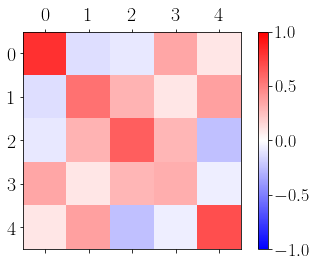

In [4]:
# We are going to sample from a projection DPP of rank k, with a ground set of size N
N = 5
k = 3
seed = 1
np.random.seed(seed)
Q, _ = np.linalg.qr(np.random.randn(N, N))
W = Q[:k,:]
K = W.T @ W # the DPP kernel

vmin = -1
vmax = 1
fig, ax = plt.subplots(1, 1)
cmap_str = "bwr"
im = ax.matshow(K, cmap=cmap_str, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
cbar.ax.tick_params(labelsize=18)
plt.savefig("../fig/dpp1_kernel.pdf")
plt.show()

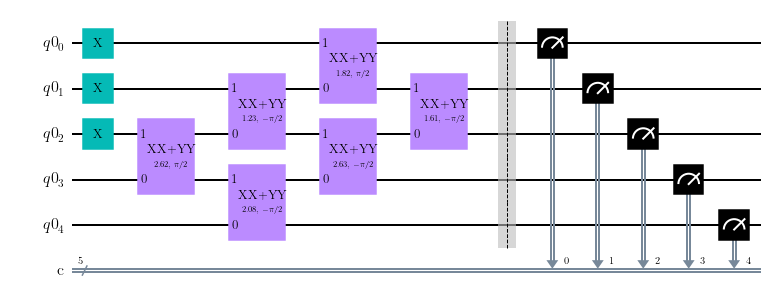

In [5]:
# Create the circuit using parallel QR as in [Jiang et al. 08]
circuit = SlaterDeterminant(W)

# Add measurements
meas = qk.QuantumCircuit(N, N) # N qubits, N classical bits
meas.barrier(range(N)) # the barrier is optional, it is an instruction for the later transpiler
meas.measure(range(N), range(N)) # perform the measurement, record it in the classical bits
circuit.add_register(meas.cregs[0])
qc = circuit.compose(meas)

# Draw the circuit
qc.draw(
    output="mpl", 
    filename="../fig/example_circuit.pdf"
)

In [6]:
# Import Aer and set the backend simulator
from qiskit import Aer
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator, we do several repeats to get 
# the distribution of the TV between the empirical measure and the underlying DPP.
tv_distances = []
num_repeats = 1000
num_shots = 20000
for _ in range(num_repeats):
    job_sim = backend_sim.run(
        qk.transpile(qc, backend_sim), 
        shots=num_shots
    )
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    proba, proba_estimated = utilities.get_estimated_probabilities(K, counts, num_shots, N)
    tv_distances.append(
        0.5*np.sum([np.abs(proba[key]-proba_estimated[key]) for key in proba])
    )

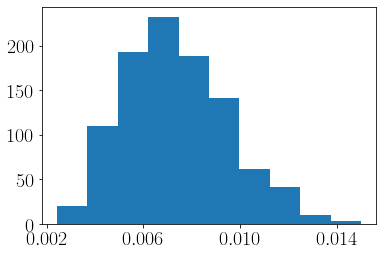

In [7]:
plt.hist(tv_distances)
plt.xticks(fontsize=20)
plt.xticks([0.002, 0.006, 0.010, 0.014])
plt.yticks(fontsize=20)
plt.xticks()
plt.savefig("../fig/dpp1_tv.pdf")
plt.show()

<AxesSubplot:xlabel='outcome'>

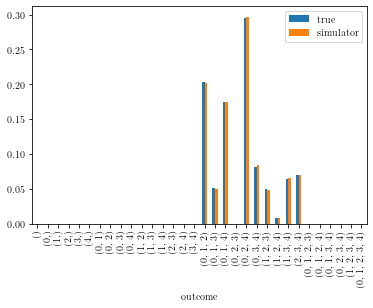

In [8]:
# Let us store the expected and estimated frequencies in a dataframe, 
# which we will complete later on with actual samples from IBMQ machines.
proba_series = pd.Series(proba.values(), index=list(proba.keys()), name="true")
proba_estimated_series = pd.Series(proba_estimated.values(), index=list(proba_estimated.keys()), name="simulator")
proba_series.index.name = "outcome"
proba_estimated_series.index.name = "outcome"
df = pd.merge(proba_series, proba_estimated_series, on="outcome")
df.plot.bar()

## Playing with runtime service

In [9]:
from qiskit import IBMQ
#IBMQ.save_account(token="d49116c77d3da82726511afa9ee1151af8904a0a5bdd3a011fb2dd4c08a3d564aa02eae1fecae56400bc169a51ceb9ec65955372b2820f5b726b4613f99bfb3a")
IBMQ.load_account()
IBMQ.providers()

/var/folders/b7/w5j5st2x5d9f77725jtxfcqh0000gn/T/ipykernel_70964/3610516010.py:3: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/var/folders/b7/w5j5st2x5d9f77725jtxfcqh0000gn/T/ipykernel_70964/3610516010.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

In [ ]:
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub='ibm-q')
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
print(small_devices)
print("Of which the least busy is")
least_busy(small_devices)

In [ ]:
backend = small_devices[-1]
print(backend)

In [ ]:
num_shots = int(20000) 
job = backend.run(
    qk.transpile(qc, backend), 
    shots=num_shots
)

In [ ]:
print(job.status())
print(job.job_id())


In [ ]:
# Looking at results for seed=1
jobnames = {"manila": "ch8eagrmre35qqp33dt0", "quito": "ch8erepccmlc5k952hog", "lima": "ch97r24rpl4d0vo0iltg"}
df_results = df.copy()
for machine, jobid in jobnames.items():
    series = utilities.load_ibm_result_csv_file(file_name="data/"+jobid+"_histogram.csv", column_name=machine, num_shots=num_shots)
    df_results = df_results.join(series, on="outcome")
    print(df_results[machine].sum())
    
df_results.describe()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=((14,5)))
df_results.plot.bar(ax=ax,width=.8)
plt.tight_layout()
plt.savefig("../fig/dpp1_results.pdf")
plt.show()

In [ ]:
# chi-squared statistics would be infinite, so we rather check the TV and compare it to its distribution under the null
for machine in jobnames:
    tv = 0.5*np.sum( np.abs(df_results["true"]-df_results[machine]) )
    print(machine, tv)